In [1]:
%matplotlib inline 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

2024-05-17 16:33:07.006847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 16:33:07.006964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 16:33:07.145385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Processing

In [2]:
home_dir = '/kaggle/input/utkface-new/UTKFace'

# Check the image name to retrieve the labels
temp_lst = os.listdir(home_dir)
temp_lst[0]

'26_0_2_20170104023102422.jpg.chip.jpg'

In [3]:
# Image path, age and gender
full_paths = []
ages = []
genders = []

# Parse the directory
for filename in tqdm(os.listdir(home_dir)):
    age, gender = filename.split('_')[:2]
    # append all paths and labels
    full_paths.append(os.path.join(home_dir, filename))
    ages.append(int(age))
    genders.append(int(gender))        

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
# Create a DataFrame
data = pd.DataFrame({
    'path': full_paths,
    'age': ages,
    'gender': genders})
data.head(10)

,path,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1
5,/kaggle/input/utkface-new/UTKFace/44_0_3_20170...,44,0
6,/kaggle/input/utkface-new/UTKFace/35_0_2_20170...,35,0
7,/kaggle/input/utkface-new/UTKFace/76_0_0_20170...,76,0
8,/kaggle/input/utkface-new/UTKFace/36_1_0_20170...,36,1
9,/kaggle/input/utkface-new/UTKFace/34_0_3_20170...,34,0


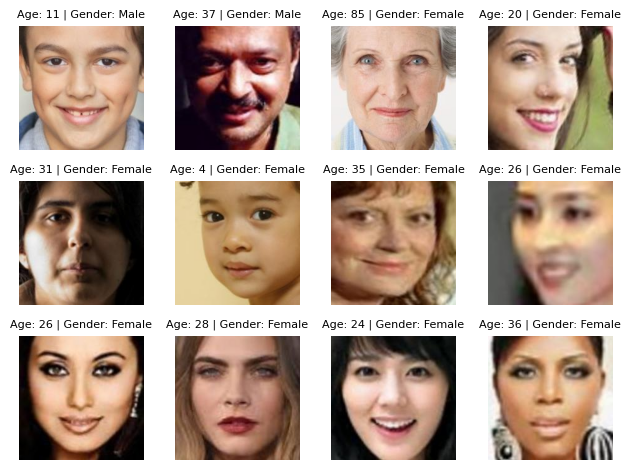

In [6]:
# Display 12 random images
data_sample = data.sample(12).reset_index(drop=True)
       
for i in range(0, 12):
    path = data_sample.loc[i, 'path']
    age = data_sample.loc[i, 'age']
    gender = 'Male' if data_sample.loc[i, 'gender'] == 0 else 'Female'
    img = plt.imread(path)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f'Age: {age} | Gender: {gender}', fontsize=8)
    plt.axis('off')
plt.tight_layout()

# Data Separation, Loading and Augmentation

In [9]:
# Split the data to train, validation and split datasets 
X_train, X_test_val = train_test_split(data, test_size=0.2, random_state=7)

# Split test and val evenly
X_test, X_val = train_test_split(X_test_val, test_size=0.5, random_state=7)

In [16]:
# Set the data generators
BATCH_SIZE=64

# Add some data augmentation
datagen_train = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9, 1.25],
    fill_mode='nearest'
)

# Datagen for val and test
datagen_val_test = ImageDataGenerator(rescale=1/255.)

train_generator = datagen_train.flow_from_dataframe(
    dataframe=X_train,
    x_col='path',
    y_col=['age', 'gender'],
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='multi_output'
)

val_generator = datagen_val_test.flow_from_dataframe(
    dataframe=X_val,
    x_col='path',
    y_col=['age', 'gender'],
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='multi_output'
)

test_generator = datagen_val_test.flow_from_dataframe(
    dataframe=X_test,
    x_col='path',
    y_col=['age', 'gender'],
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='multi_output',
)

Found 18966 validated image filenames.
Found 2371 validated image filenames.
Found 2371 validated image filenames.


In [17]:
# # Generate a batch of data
# batch = next(train_generator)

# # Unpack the batch
# images, labels = batch

# # Print the type and structure of labels
# print(f"Labels type: {type(labels)}")
# print(f"Labels structure: {labels}")

# # Check if labels is a dictionary and unpack
# if isinstance(labels, dict):
#     ages, genders = labels['age_out'], labels['gender_out']
#     print(f"Ages shape: {ages.shape}, type: {type(ages)}")
#     print(f"Genders shape: {genders.shape}, type: {type(genders)}")
# else:
#     print("Labels are not in the expected dictionary format.")
#     # Assuming labels is a list, unpack it directly
#     ages, genders = labels

# # Check the structure of the images
# print(f"Images shape: {images.shape}")

# # Display the first image and its labels as a sample check
# plt.imshow(images[0])
# plt.title(f'Age: {ages[0]} | Gender: {"Male" if genders[0] == 0 else "Female"}')
# plt.axis('off')
# plt.show()

from tensorflow.keras.utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, generator):
        self.generator = generator
    
    def __len__(self):
        return len(self.generator)
    
    def __getitem__(self, index):
        images, labels = self.generator[index]
        age_labels, gender_labels = labels
        return images, {'age_out': age_labels, 'gender_out': gender_labels}
    
    def on_epoch_end(self):
        self.generator.on_epoch_end()
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item

train_generator = CustomDataGenerator(train_generator)
val_generator = CustomDataGenerator(val_generator)
test_generator = CustomDataGenerator(test_generator)

# Model Creation and Fine Tuning

In [18]:
# The base model - InceptionV3
base = InceptionV3(include_top = False, weights='imagenet', input_shape=(128, 128, 3))

for layer in base.layers[:136]:
    layer.trainable = False
for layer in base.layers[136:]:
    layer.trainable = True

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [19]:
# Output braches with FLC layers
x = base.output # base model
x = GlobalAveragePooling2D()(x) # Global Pool before dividing into branches

# First branch for gender prediction
gender = Dense(512, activation='relu')(x)
gender = Dropout(0.5)(gender)
gender_out = Dense(1, activation='sigmoid', name='gender_out')(gender)

# Second branch for age prediction
age = Dense(512, activation='relu')(x)
age = Dropout(0.5)(age)
age_out = Dense(1, activation='linear', name='age_out')(age)

# Create the model
model = Model(inputs=base.input, outputs=[age_out, gender_out])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 63, 63,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 61, 61,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 30,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 23,901,986 (91.18 MB)

 Trainable params: 20,306,658 (77.46 MB)

 Non-trainable params: 3,595,328 (13.72 MB)

In [22]:
# Add callbacks and optimiser 
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,          
    patience=5,          
    min_lr=0.00001,      
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    verbose=1,
    restore_best_weights=True
)
    
adam = Adam(learning_rate=0.001)

In [25]:
# Compile and start training 
model.compile(optimizer=adam,
               loss={'age_out': 'mse', 'gender_out': 'binary_crossentropy'},
               metrics={'gender_out': 'accuracy', 'age_out': 'mae'})

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/297 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - age_out_mae: 34.6808 - gender_out_accuracy: 0.4414 - loss: 1604.6079   

I0000 00:00:1715964890.028483     253 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


297/297 ━━━━━━━━━━━━━━━━━━━━ 245s 625ms/step - age_out_mae: 10.8522 - gender_out_accuracy: 0.6212 - loss: 238.0687 - val_age_out_mae: 7.2306 - val_gender_out_accuracy: 0.7149 - val_loss: 108.3836 - learning_rate: 0.0010
Epoch 2/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 101s 333ms/step - age_out_mae: 7.1240 - gender_out_accuracy: 0.6924 - loss: 97.6839 - val_age_out_mae: 6.5555 - val_gender_out_accuracy: 0.7672 - val_loss: 86.1868 - learning_rate: 0.0010
Epoch 3/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 100s 329ms/step - age_out_mae: 6.9363 - gender_out_accuracy: 0.7359 - loss: 93.1561 - val_age_out_mae: 6.2310 - val_gender_out_accuracy: 0.7558 - val_loss: 75.0577 - learning_rate: 0.0010
Epoch 4/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 102s 334ms/step - age_out_mae: 6.5047 - gender_out_accuracy: 0.7474 - loss: 81.2478 - val_age_out_mae: 8.4661 - val_gender_out_accuracy: 0.7545 - val_loss: 151.8911 - learning_rate: 0.0010
Epoch 5/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 101s 332ms/step - age_out_mae: 6.3746 - gender_out_accu

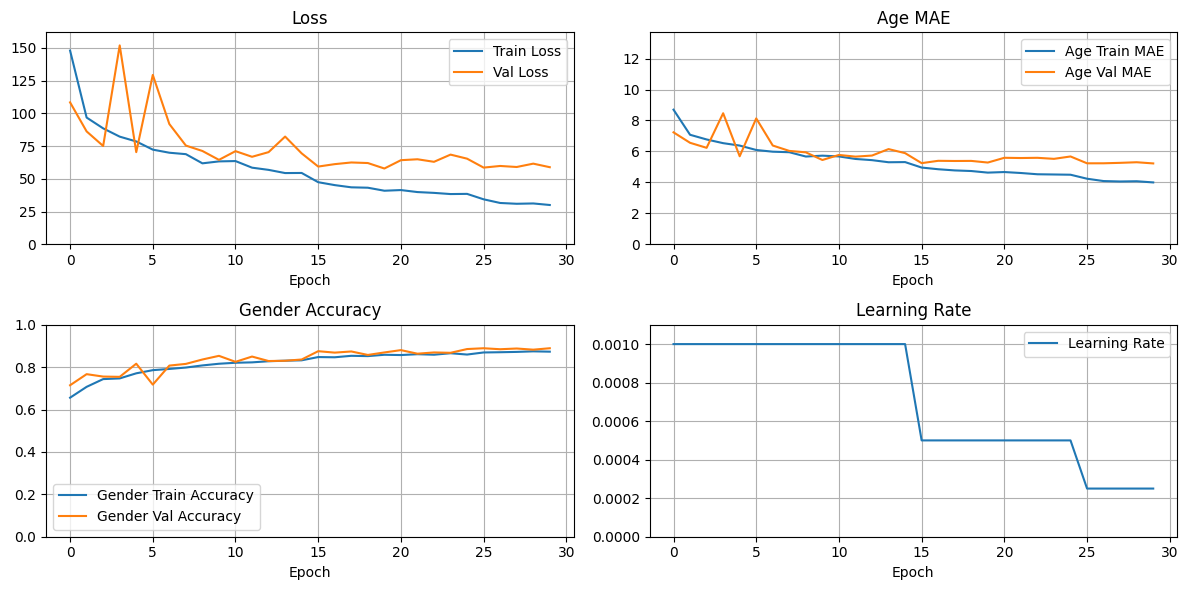

In [28]:
fig = plt.figure(figsize=(12, 6))

# Loss
fig.add_subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.grid(True)
plt.ylim([0, max(max(history.history['loss']), max(history.history['val_loss'])) + 10])
plt.title('Loss')
plt.xlabel('Epoch')

# Age MAE
fig.add_subplot(2, 2, 2)
plt.plot(history.history['age_out_mae'], label='Age Train MAE')
plt.plot(history.history['val_age_out_mae'], label='Age Val MAE')
plt.legend()
plt.grid(True)
plt.ylim([0, max(max(history.history['age_out_mae']), max(history.history['val_age_out_mae'])) + 5])
plt.title('Age MAE')
plt.xlabel('Epoch')

# Gender Accuracy
fig.add_subplot(2, 2, 3)
plt.plot(history.history['gender_out_accuracy'], label='Gender Train Accuracy')
plt.plot(history.history['val_gender_out_accuracy'], label='Gender Val Accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0, 1.0])
plt.title('Gender Accuracy')
plt.xlabel('Epoch')

# Learning Rate
fig.add_subplot(2, 2, 4)
plt.plot(history.history['learning_rate'], label='Learning Rate')
plt.legend()
plt.grid(True)
plt.ylim([0, max(history.history['learning_rate']) + 0.0001])
plt.title('Learning Rate')
plt.xlabel('Epoch')

# Plot
plt.tight_layout()
plt.show()

In [30]:
# Evaluate on a test set
test_loss, test_age_mae, test_gender_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Age MAE:", test_age_mae)
print("Test Gender Accuracy:", test_gender_accuracy)

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - age_out_mae: 5.0108 - gender_out_accuracy: 0.8651 - loss: 50.5392
Test Loss: 51.91027069091797
Test Age MAE: 5.030325412750244
Test Gender Accuracy: 0.8544917702674866
